In [1]:
#Général
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
import datetime
import time
from tqdm import tqdm

#Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#Modèles
from sklearn import cluster
from sklearn.cluster import KMeans

#Réduction des dimensions
from sklearn.decomposition import PCA

#Métriques
from sklearn.metrics import adjusted_rand_score

#Visualisation
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns

In [2]:
df=pd.read_csv('df33d.csv')

## Maintenance du modèle

In [3]:
#On va utiliser un échantillon aléatoire
df1=df.sample(n=30000)

In [4]:
#On convertit la date texte en date type datetime.datetime
date_init=datetime.datetime.strptime('2017-09-01 00:00:00', '%Y-%m-%d %H:%M:%S')
date_init_str = '2017-09-01 00:00:00'

In [5]:
#on réduit la base aux customer_unique_id de la période d'initialisation de la base
rows = df1.loc[df1['order_purchase_timestamp']<date_init_str,:]['customer_unique_id'].unique()
data = df1.loc[df1['customer_unique_id'].isin(rows),:]

In [6]:
#la fonction
def data_(data,date):
    # 3-3-c Définition de nouvelles variables

    #data.order_purchase_timestamp.astype('float64')
    df33cr = data.loc[data.order_purchase_timestamp < date]


    #tri de la base par date d'achat
    df33cr = df33cr.sort_values('order_purchase_timestamp')

   
    dt_base = datetime.datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    type(dt_base)

    df33cr

    #3-3-e Regroupement de la base par client unique

    #df33x=df33cr.groupby('customer_unique_id').mean()
    df33x=df33cr.groupby('customer_unique_id').agg({'review_score':['mean'],
                                                'payment_sequential':['mean'],
                                                'payment_installments':['mean'],
                                                'payment_value':['mean'],
                                                'price':['mean'],
                                                'freight_value':['mean'],
                                                'Recence':['last'],
                                                'Frequence':['last'], 
                                                'Montant':['last'],
                                                'payment_type_boleto':['mean'],
                                                'payment_type_credit_card':['mean'], 
                                                'payment_type_debit_card':['mean'],
                                                'payment_type_voucher':['mean'],
                                                'product_category_name_english_Alimentation':['mean'],
                                                'product_category_name_english_Animaux_de_compagnie':['mean'],
                                                'product_category_name_english_Auto_moto':['mean'],
                                                'product_category_name_english_Enfant_bébé':['mean'],
                                                'product_category_name_english_High-tech_électronique':['mean'],
                                                'product_category_name_english_Loisirs_culture_divertissement':['mean'],
                                                'product_category_name_english_Maison_jardin':['mean'],
                                                'product_category_name_english_Mode_accessoires':['mean'],
                                                'product_category_name_english_Outils_construction':['mean'],
                                                'product_category_name_english_Papeterie_bureau':['mean'],
                                                'product_category_name_english_Santé_beauté':['mean']
                                                })
       
    return(df33x)   #

In [7]:
#les données initales
B_init=data_(data,date_init_str)

In [8]:
#pour info
min(df['order_purchase_timestamp'])

'2016-09-05 00:15:34'

In [9]:
#pour info
max(df['order_purchase_timestamp'])

'2018-10-17 17:30:18'

In [10]:
#le modèle
model = Pipeline([('pca' , PCA(n_components = 5)),
                 ('scaler', RobustScaler()),
                 ('model', KMeans(n_clusters=3, init='k-means++', random_state=42))
                ])

In [11]:
dates=[str(date_init+datetime.timedelta(30*i)) for i in range(21)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [12]:
# bouclage pour créer la liste des données mises à jour
# Par mois
dates=[str(date_init+datetime.timedelta(30*i)) for i in range(20)]
dfi_t = pd.DataFrame()

for i in range(len(dates)):
    dfi=data_(data,dates[i])

    #rajout d'une colonne date_i à dfi
    dfi['date_i'] = dates[i]
    dfi_t = pd.concat([dfi_t,dfi] , ignore_index = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129200 entries, 0 to 129199
Data columns (total 25 columns):
 #   Column                                                                Non-Null Count   Dtype  
---  ------                                                                --------------   -----  
 0   (review_score, mean)                                                  129200 non-null  float64
 1   (payment_sequential, mean)                                            129200 non-null  float64
 2   (payment_installments, mean)                                          129200 non-null  float64
 3   (payment_value, mean)                                                 129200 non-null  float64
 4   (price, mean)                                                         129200 non-null  float64
 5   (freight_value, mean)                                                 129200 non-null  float64
 6   (Recence, last)                                                       129200 non-nul

In [13]:
%%time
model.fit(dfi_t.select_dtypes(exclude = 'object'))
labels_dfi_t = model.named_steps['model'].labels_

CPU times: total: 3.31 s
Wall time: 1.94 s


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.54it/s]


CPU times: total: 578 ms
Wall time: 642 ms


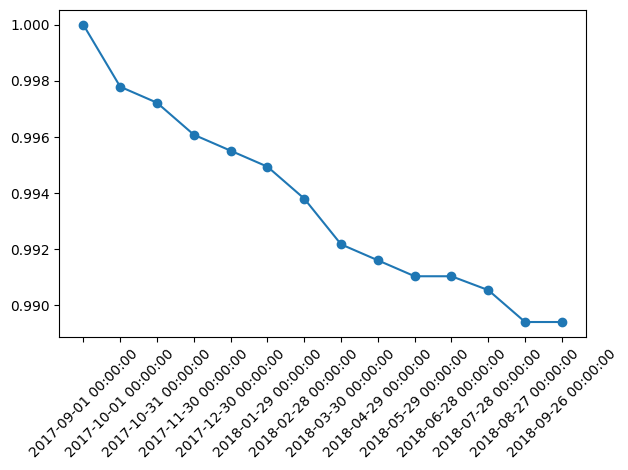

In [14]:
%%time
# bouclage pour créer la liste des RI
dfi_t['cluster'] = labels_dfi_t

# Par mois
dates=[str(date_init+datetime.timedelta(30*i)) for i in range(14)]
dates
ARI = []
for i in tqdm(range(len(dates))):
    
    Ri=adjusted_rand_score(dfi_t.loc[dfi_t['date_i'] == dates[0]]['cluster'],
                           dfi_t.loc[dfi_t['date_i'] == dates[i]]['cluster'])
    ARI.append(Ri)
   
plt.plot(dates[0:len(dates)],ARI,'o',ls = '-')
plt.xticks(rotation=45,fontsize=10)
plt.tight_layout()